In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/edsa-recommender-system-predict/sample_submission.csv
/kaggle/input/edsa-recommender-system-predict/genome_tags.csv
/kaggle/input/edsa-recommender-system-predict/tags.csv
/kaggle/input/edsa-recommender-system-predict/imdb_data.csv
/kaggle/input/edsa-recommender-system-predict/genome_scores.csv
/kaggle/input/edsa-recommender-system-predict/movies.csv
/kaggle/input/edsa-recommender-system-predict/links.csv
/kaggle/input/edsa-recommender-system-predict/test.csv
/kaggle/input/edsa-recommender-system-predict/train.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

'''Plotly visualization .'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
py.init_notebook_mode(connected = True) # Required to use plotly offline in jupyter notebook

import cufflinks as cf #importing plotly and cufflinks in offline mode  
import plotly.offline  
cf.go_offline()  
cf.set_config_file(offline=False, world_readable=True)




In [2]:
train=pd.read_csv( '/kaggle/input/edsa-recommender-system-predict/train.csv')
movies=pd.read_csv('/kaggle/input/edsa-recommender-system-predict/movies.csv')
imdb = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/imdb_data.csv')


In [3]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [6]:
movies.genres = movies.genres.str.split('|')
movies = explode(movies, ['genres'])
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure
1,1,Toy Story (1995),Animation
2,1,Toy Story (1995),Children
3,1,Toy Story (1995),Comedy
4,1,Toy Story (1995),Fantasy


In [7]:
# Storing the years from the titles separately:

# We specify the parantheses so we don’t conflict with movies that have years in their titles
movies["year"] = movies.title.str.extract("(\(\d\d\d\d\))",expand=False)
# Removing the parentheses
movies["year"] = movies.year.str.extract("(\d\d\d\d)",expand=False)
# Removing the years from the ‘title’ column
movies["title"] = movies.title.str.replace("(\(\d\d\d\d\))", "")
# Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies["title"] = movies["title"].apply(lambda x: x.strip())

In [8]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure,1995
1,1,Toy Story,Animation,1995
2,1,Toy Story,Children,1995
3,1,Toy Story,Comedy,1995
4,1,Toy Story,Fantasy,1995


In [9]:
  import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

'''Plotly visualization .'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
py.init_notebook_mode(connected = True) # Required to use plotly offline in jupyter notebook

import cufflinks as cf #importing plotly and cufflinks in offline mode  
import plotly.offline  
cf.go_offline()  
cf.set_config_file(offline=False, world_readable=True)

'''Display markdown formatted output like bold, italic bold etc.'''
from IPython.display import Markdown
def bold(string):
     display(Markdown(string))

In [10]:
temp_df = train['rating'].value_counts().reset_index()


# create trace1
trace1 = go.Bar(
                x = movies['genres'],
                y = temp_df['rating'],
                marker = dict(color = 'dark blue',
                              line=dict(color='rgb(0,0,0)',width=1.5)))
layout = go.Layout(template= "plotly_white",title = 'NUMBER OF RATINGS PER GENRE' , xaxis = dict(title = 'Rating'), yaxis = dict(title = 'Count'))
fig = go.Figure(data = [trace1], layout = layout)
fig.show()



In [11]:
ratings = train.copy()

In [12]:
import time
ratings['timestamp'] = train['timestamp'].apply(lambda x: time.strftime('%Y', time.localtime(x)))


In [13]:
ratings = ratings.merge(movies, left_on='movieId', right_on='movieId')
ratings.head()

,userId,movieId,rating,timestamp,title,genres,year
0,5163,57669,4.0,2018,In Bruges,Comedy,2008
1,5163,57669,4.0,2018,In Bruges,Crime,2008
2,5163,57669,4.0,2018,In Bruges,Drama,2008
3,5163,57669,4.0,2018,In Bruges,Thriller,2008
4,87388,57669,3.5,2009,In Bruges,Comedy,2008


In [14]:
popular_genre = pd.DataFrame(ratings['genres'].value_counts()).reset_index()
popular_genre.columns = ['genres', 'movies']


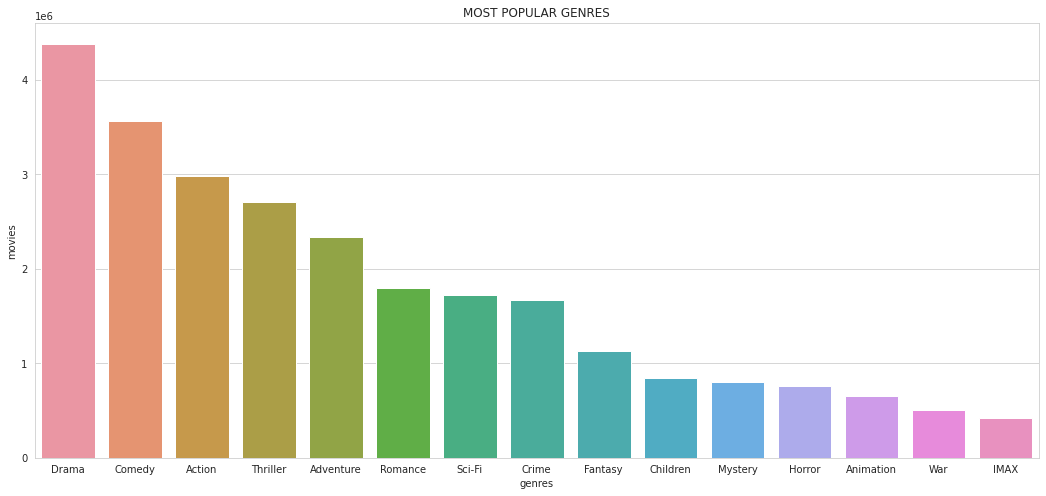

In [15]:
plt.figure(figsize=(18,8))
sns.barplot(x='genres', y='movies', data=popular_genre.head(15))
plt.title("MOST POPULAR GENRES")
plt.show()

In [16]:
ratings['year']= pd.to_numeric(ratings['year'])

In [17]:
ratings['genres']= ratings['genres'].astype('str')

In [18]:
genres = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Horror', 'Mystery', 'Romance', 'Thriller']

In [19]:
pop_gen_movies = ratings[(ratings['genres'].isin(genres)) & (ratings['year'] >= 1995) & (ratings['year'] <= 2018)]
ctab = pd.crosstab([pop_gen_movies['year']], pop_gen_movies['genres']).apply(lambda x: x/x.sum(), axis=1)


In [20]:
ctab.columns

Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama',
       'Horror', 'Mystery', 'Romance', 'Thriller'],
      dtype='object', name='genres')

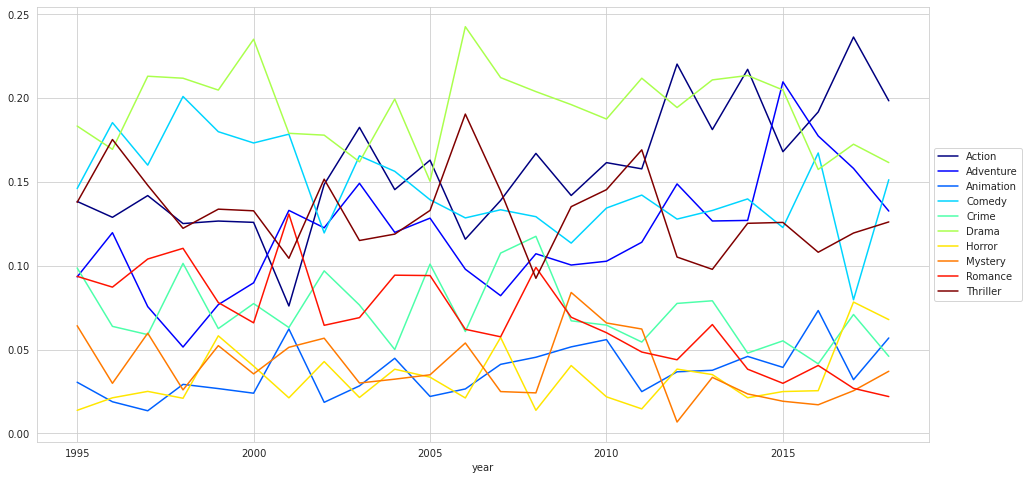

In [24]:
ctab[genres].plot(kind='line', stacked=False, colormap='jet', figsize=(16,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [25]:
ratings['timestamp']=pd.to_numeric(ratings['timestamp'])

In [26]:
movie_1 = ratings.loc[ratings['genres'].isin(genres)]
mean_ratings = movie_1.groupby([ 'genres', 'timestamp'], 
                               as_index=False)['rating'].agg(['mean', 'std', 'count'])



In [27]:
movie_1.head()

,userId,movieId,rating,timestamp,title,genres,year
0,5163,57669,4.0,2018,In Bruges,Comedy,2008.0
1,5163,57669,4.0,2018,In Bruges,Crime,2008.0
2,5163,57669,4.0,2018,In Bruges,Drama,2008.0
3,5163,57669,4.0,2018,In Bruges,Thriller,2008.0
4,87388,57669,3.5,2009,In Bruges,Comedy,2008.0


NameError: name 'cory' is not defined

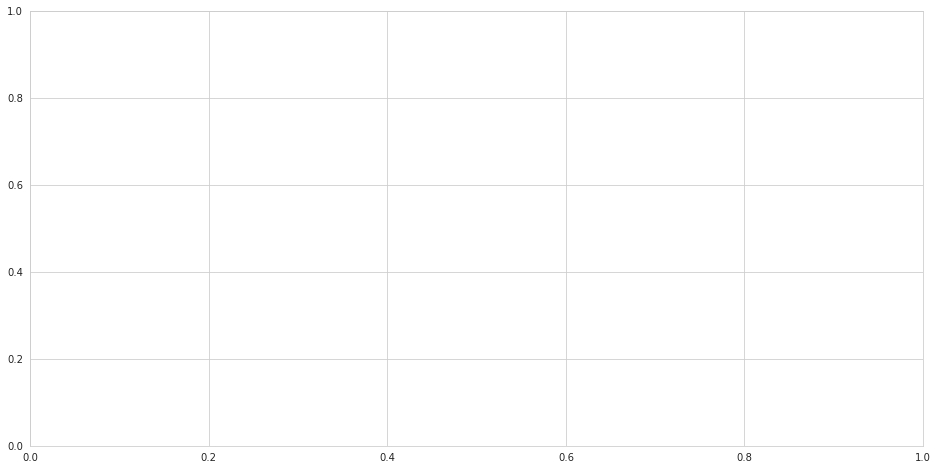

In [31]:

# Year Made vs Rating by Genre
data = pd.DataFrame()

for i in genres:
    g1 = mean_ratings.loc[i]
    s1 = g1.loc[:]['mean']
    s1 = pd.Series(s1)
    data = pd.concat([data,s1], axis=1)
    
data.columns = genres
mean_fill = data.fillna(data.mean())
correlation = mean_fill.corr()
plt.subplots(figsize=(16,8))
sns.heatmap(correlation, annot=True)
